### Load Packages and Data

In [1]:
# Load packages

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import all_estimators
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_validate, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE, SelectFromModel, SequentialFeatureSelector, RFECV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, Perceptron, SGDClassifier

In [2]:
spotify_data = pd.read_csv('spotify_data.csv')

In [3]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

In [4]:
spotify_data.head()

acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8    0.0763   -28.454     1   
2    5    0.1190   -19.924     0   
3    1    0.1110   -14.734     0   
4   11    0.0980   -16.829     1   

                                            name  popularity release_date  \
0                    Singende Bataillone 1. Teil           0         1928   
1       Fantasiestücke, Op. 111: Più tosto lento           0         1928   
2                 Chapter 1.18 - Zamek kaniowski           0         1928   
3  Bebamos Juntos - Instrumental (Remasterizado)           0   1928-09-25   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1         1928   

   speechiness    tempo  valence  year  
0       0.0506  118.469   0.7790  1928  
1       0.0462   83.972   0.0767  1928  
2       0.9290  107.177   0.8800  1928  
3       0.0926  108.003   0.7200  1928  
4       0.0424   62.149   0.0693  1928

### Data Cleaning

In [5]:
numerical_cols = list(spotify_data.select_dtypes(int).columns)
dummy_cols = list(spotify_data.select_dtypes(object).columns)

In [6]:
print(dummy_cols)

['artists', 'id', 'name', 'release_date']


All of these columns will not be used in dataset

In [7]:
no_variance_cols = []
for col in spotify_data.columns:
  if len(spotify_data[col].value_counts()) == 1:
    print(f"Dropping column: {col}")
    numerical_cols.remove(col)
    no_variance_cols.append(col)

spotify_data = spotify_data.drop(no_variance_cols, axis = 1)

In [8]:
spotify_data['year']

0         1928
1         1928
2         1928
3         1928
4         1928
          ... 
169904    2020
169905    2020
169906    2020
169907    2020
169908    2020
Name: year, Length: 169909, dtype: int64

In [9]:
def create_decades(row):
  curr_year = row['year']
  dec_year = curr_year - int(str(curr_year)[-1])

  return f"{dec_year}s"

In [10]:
spotify_data['decade'] = spotify_data.apply(lambda row: create_decades(row), axis = 1)

In [11]:
spotify_data['decade'].value_counts()

1960s    20000
1970s    20000
1980s    20000
1990s    20000
2000s    20000
1950s    19950
2010s    19900
1940s    14968
1930s     8889
1920s     4446
2020s     1756
Name: decade, dtype: int64

In [12]:
spotify_data_with_dummies = pd.get_dummies(spotify_data, columns = ['decade'])

In [13]:
spotify_data_with_dummies.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'decade_1920s', 'decade_1930s', 'decade_1940s',
       'decade_1950s', 'decade_1960s', 'decade_1970s', 'decade_1980s',
       'decade_1990s', 'decade_2000s', 'decade_2010s', 'decade_2020s'],
      dtype='object')

In [14]:
metric_cols = list(spotify_data_with_dummies.select_dtypes(float).columns)

In [15]:
metric_cols

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [16]:
decade_cols = [col for col in spotify_data_with_dummies.columns if 'decade' in col]

### Feature Engineering

In [17]:
X_unscaled_all = spotify_data_with_dummies.drop(dummy_cols, axis=1)

In [18]:
X_unscaled_all_interactions = X_unscaled_all.copy()

The code below creates interaction terms for every song metric + decade

In [19]:
for col in metric_cols:
  for decade in decade_cols:
    new_col = f"{col} {decade}"
    X_unscaled_all_interactions[new_col] = X_unscaled_all[col] * X_unscaled_all[decade]

<ipython-input-19-d07f48d8c16e>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_unscaled_all_interactions[new_col] = X_unscaled_all[col] * X_unscaled_all[decade]


In [20]:
X_unscaled_all = X_unscaled_all.drop(decade_cols + ['year'], axis = 1)
X_unscaled_all_interactions = X_unscaled_all_interactions.drop(decade_cols + ['year'], axis = 1)

### EDA: 

#### Popularity relationships

In [151]:
def scatterplots_subplot():
  plt.figure(figsize=(16,16))

  plotted = 0
  for col in metric_cols:
    plt.subplot(3,3,plotted+1)

    sns.scatterplot(y = 'popularity', x = col, data = spotify_data_with_dummies)
    plt.title(f'Scatter plot of {col} with Popularity')
    plotted +=1

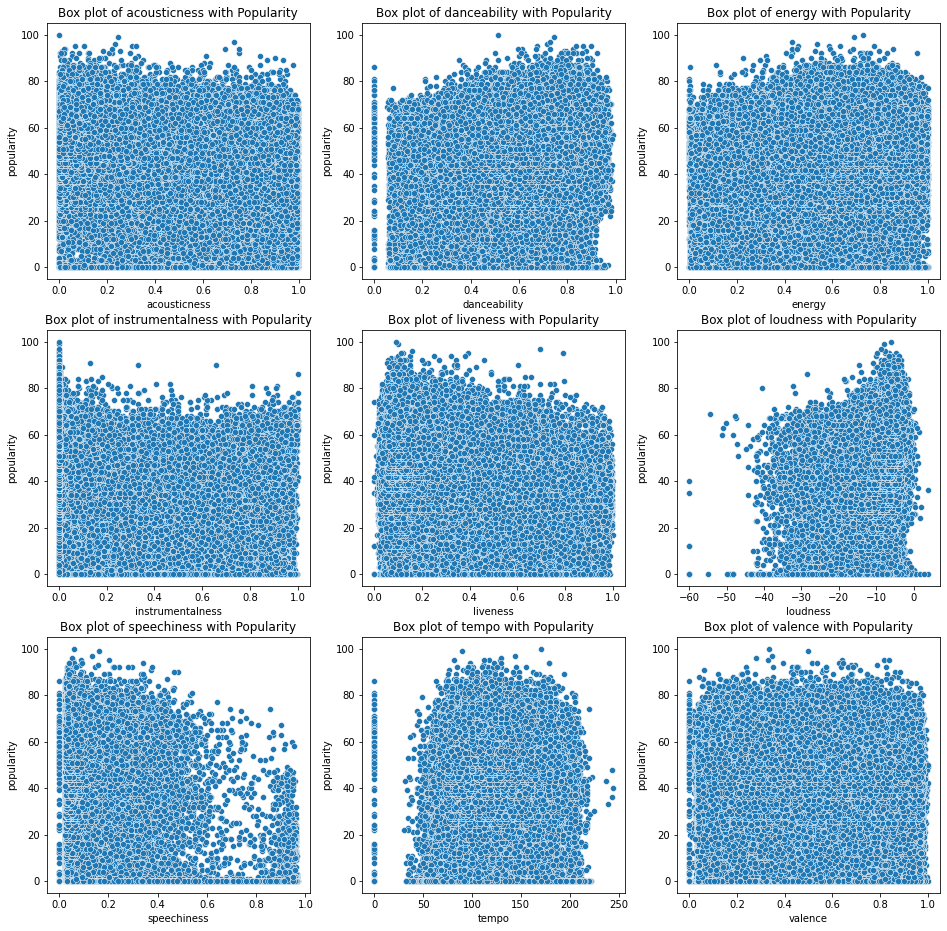

In [24]:
scatterplots_subplot()

Clear outliers with tempo 0. and danceability 0- may be interesting to explore some outliers

In [25]:
spotify_data_with_dummies[ (spotify_data_with_dummies['tempo'] == 0) & (spotify_data_with_dummies['popularity'] > 70)][['artists', 'name', 'popularity']]

artists  \
87456   ['White Noise Meditation', 'Lullaby Land', 'Wh...   
87651                                        ['Granular']   
87652                                        ['Granular']   
87653   ['Erik Eriksson', 'White Noise Baby Sleep', 'W...   
97541                           ['High Altitude Samples']   
107149                        ['Microdynamic Recordings']   
116201  ['White Noise Baby Sleep', 'White Noise for Ba...   
116385  ['Erik Eriksson', 'White Noise for Babies', 'W...   
116623                                     ['Bruce Brus']   
135281                                        ['Zenibly']   

                                             name  popularity  
87456         Brown Noise - Loopable with No Fade          74  
87651                        White Noise - 500 hz          81  
87652                        White Noise - 145 hz          80  
87653   Clean White Noise - Loopable with no fade          86  
97541                            Soft Brown Noise          78  
107149                                  Calm Pour          76  
116201                     The Early Morning Rain          71  
116385   Pure Brown Noise - Loopable with no fade          74  
116623                 White Noise Crashing Waves          76  
135281                   Clean & Pure White Noise          71

In [26]:
spotify_data_with_dummies[ (spotify_data_with_dummies['danceability'] == 0) & (spotify_data_with_dummies['popularity'] > 70)][['artists', 'name', 'popularity']]

artists  \
87456   ['White Noise Meditation', 'Lullaby Land', 'Wh...   
87651                                        ['Granular']   
87652                                        ['Granular']   
87653   ['Erik Eriksson', 'White Noise Baby Sleep', 'W...   
97541                           ['High Altitude Samples']   
107149                        ['Microdynamic Recordings']   
116201  ['White Noise Baby Sleep', 'White Noise for Ba...   
116385  ['Erik Eriksson', 'White Noise for Babies', 'W...   
116623                                     ['Bruce Brus']   
135281                                        ['Zenibly']   

                                             name  popularity  
87456         Brown Noise - Loopable with No Fade          74  
87651                        White Noise - 500 hz          81  
87652                        White Noise - 145 hz          80  
87653   Clean White Noise - Loopable with no fade          86  
97541                            Soft Brown Noise          78  
107149                                  Calm Pour          76  
116201                     The Early Morning Rain          71  
116385   Pure Brown Noise - Loopable with no fade          74  
116623                 White Noise Crashing Waves          76  
135281                   Clean & Pure White Noise          71

Based on this analysis, it appears that the dataset used for this project is not perfectly clean (a noisy dataset one might say), in that there we are trying to predict song popularity, but there are non-songs such as white noise and rain noises that are in the dataset, creating outlier points.

#### Decade-wise scatter plots of popularity relationships

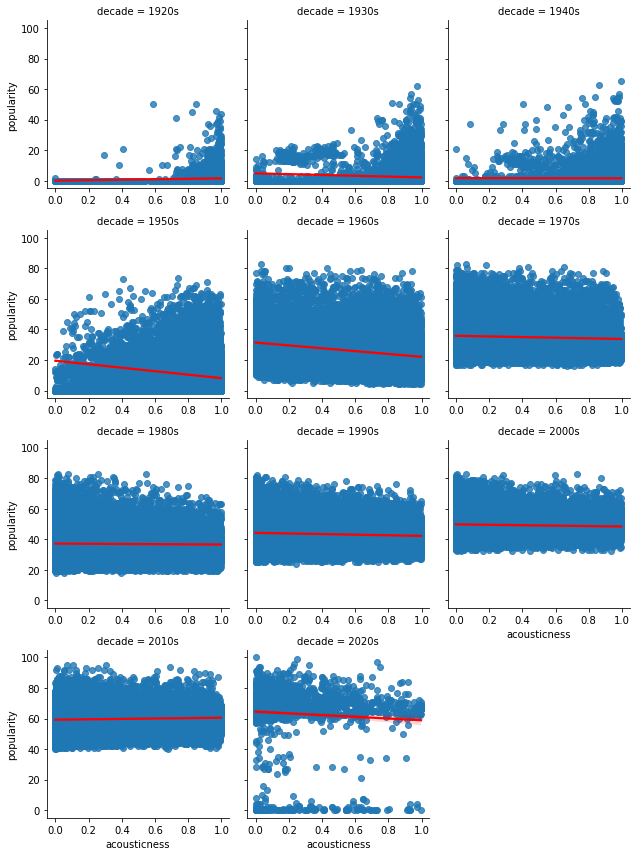

In [476]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'acousticness', "popularity", line_kws = {'color':'red'})

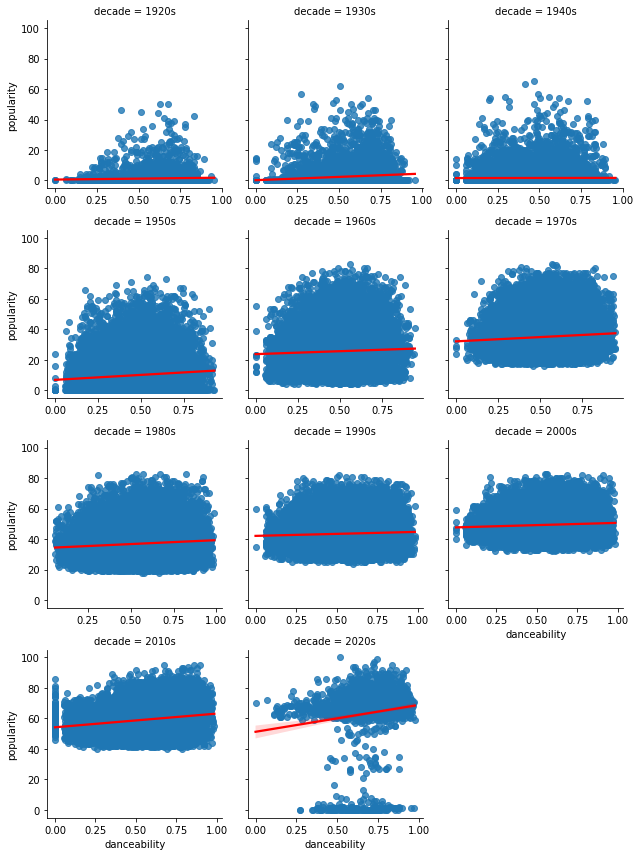

In [113]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'danceability', "popularity", line_kws = {'color':'red'})

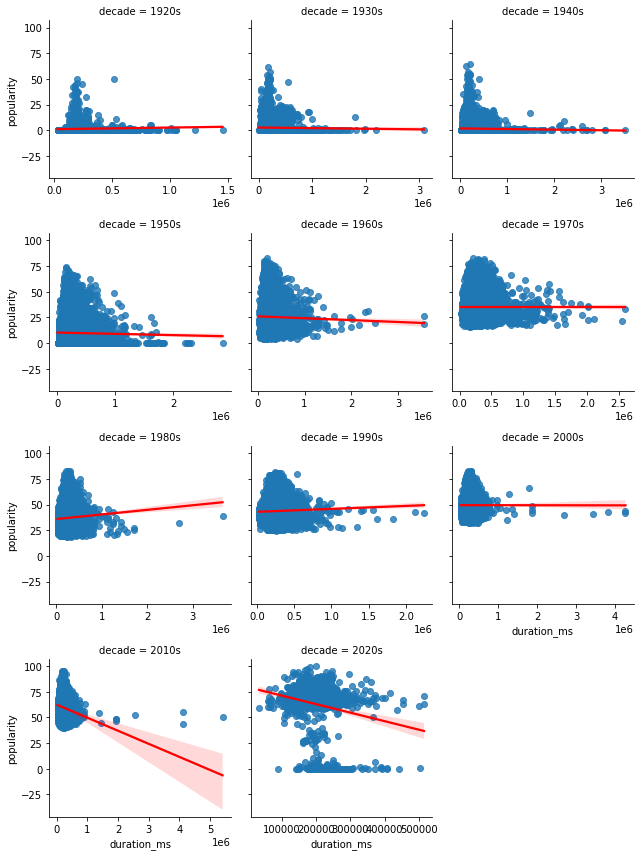

In [116]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'duration_ms', "popularity", line_kws = {'color':'red'})

There are some key leverage points here that are influencing the line plots, including songs that are extraordinarily long

The songs listed below are 3000000 milliseconds, or rather 50 Minutes. Many of these are sounds used for helping people fall asleep, as well as a few real songs, and interestingly, someone's documentation of the Yalta Conference.

In [119]:
spotify_data[spotify_data['duration_ms'] > 3000000]

acousticness                                artists  danceability  \
7411        0.111000                      ['Sound Dreamer']        0.0000   
9104        0.983000                        ['Umm Kulthum']        0.3960   
10573       0.900000                        ['Umm Kulthum']        0.4100   
38491       0.003670                              ['Sleep']        0.1600   
46427       0.776000                        ['Chuck Riley']        0.5320   
46972       0.975000                    ['Sounds for Life']        0.1530   
54511       0.000385  ['Lightning, Thunder and Rain Storm']        0.1160   
54675       0.932000                       ['Ocean Sounds']        0.0797   
72889       0.601000                       ['Environments']        0.1590   
117370      0.993000                       ['Portugallien']        0.0644   
118566      0.937000          ['Franklin Delano Roosevelt']        0.6560   
118777      0.891000                        ['Umm Kulthum']        0.3450   
125152      0.932000              ['Ocean Waves For Sleep']        0.0797   
140784      0.976000                          ['Brian Eno']        0.0918   

        duration_ms    energy  explicit                      id  \
7411        5403500  0.000099         0  7foc25ig7dibxvULPU2kBG   
9104        3089255  0.347000         0  29vwEHUHBLN5FRaHcgyXXf   
10573       3551152  0.451000         0  0AsT5HMyXuqa8qWMLv0YZb   
38491       3816373  0.572000         0  1vhvheW4R0KbK6Kr3NFplW   
46427       3432107  0.307000         0  3n6ej62cDXOS7LAPLqC0Um   
46972       4270034  0.079200         0  605JTCltCe1IcqrGXQ294K   
54511       4269407  0.338000         0  7dYf0CsWHDLvlP6HJPs3zO   
54675       4120258  0.995000         0  2QfFLpSGF1T1pY6tq4kD7Z   
72889       3557955  0.562000         0  2rRuuVflvA23Fcl8KezNAF   
117370      3093226  0.132000         0  7M2tLKFG4LJEx0rd0NqFAu   
118566      3091373  0.356000         0  4ZqyhM0W9AQL4PLnDsfdcM   
118777      3523619  0.723000         0  1gXsu5iZHLpUr1zvXEfOxw   
125152      4120258  0.995000         0  1saXdvEAafdRzUphXBzSHg   
140784      3650800  0.056900         0  4t3Yh6tKkxXrc458pNI7zZ   

        instrumentalness  key  liveness  loudness  mode  \
7411            0.392000    2    0.1370   -21.669     1   
9104            0.558000    3    0.9490   -11.557     1   
10573           0.000034    8    0.7030   -10.213     0   
38491           0.745000    5    0.0952    -6.949     1   
46427           0.000000    0    0.1160   -20.451     1   
46972           1.000000   10    0.1130   -23.962     0   
54511           0.093500    1    0.3420   -36.638     1   
54675           0.562000    1    0.3100   -17.379     1   
72889           0.611000   10    0.1070   -22.135     0   
117370          0.962000    3    0.1440   -37.943     1   
118566          0.001510    6    0.6940   -14.367     1   
118777          0.769000    9    0.3930    -7.801     1   
125152          0.562000    1    0.3100   -17.379     1   
140784          0.884000    0    0.0842   -31.808     1   

                                                  name  popularity  \
7411                          Brown Noise - 90 Minutes          50   
9104                            Yalle Kan Yshgek Anene           0   
10573                                       Enta Oumry          26   
38491                                       Dopesmoker          43   
46427                            Aladdin - Storyteller          41   
46972                            Brown Noise for Sleep          42   
54511                     Midnight Thunderstorm Part 2          44   
54675                               Ocean Waves Sounds          44   
72889   The Psychologically Ultimate Seashore (16 rpm)          19   
117370                                          Anslag           0   
118566       Address to Congress on Yalta - 03 01 1945           0   
118777                                  Naheg El Berda           0   
125152                           Ocean Waves for S

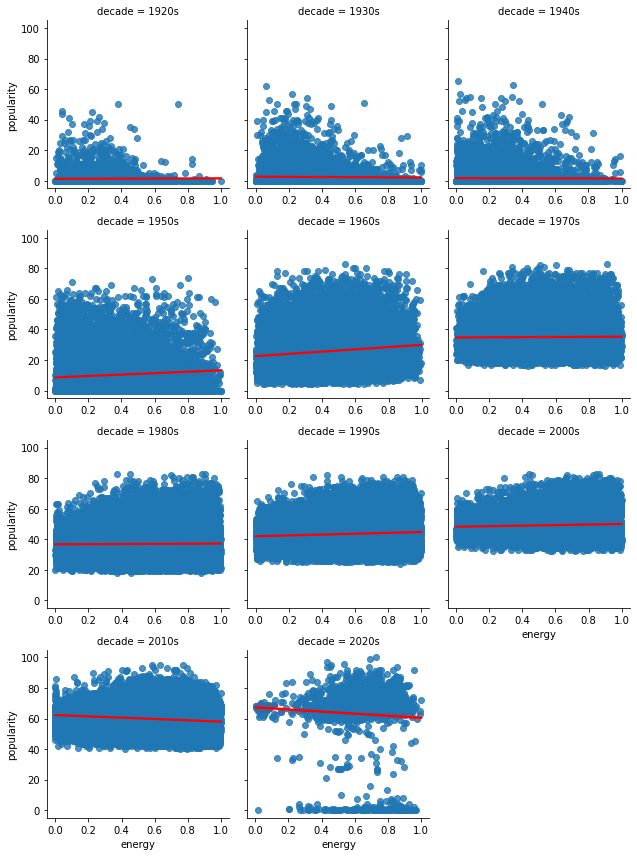

In [478]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'energy', "popularity", line_kws = {'color':'red'})

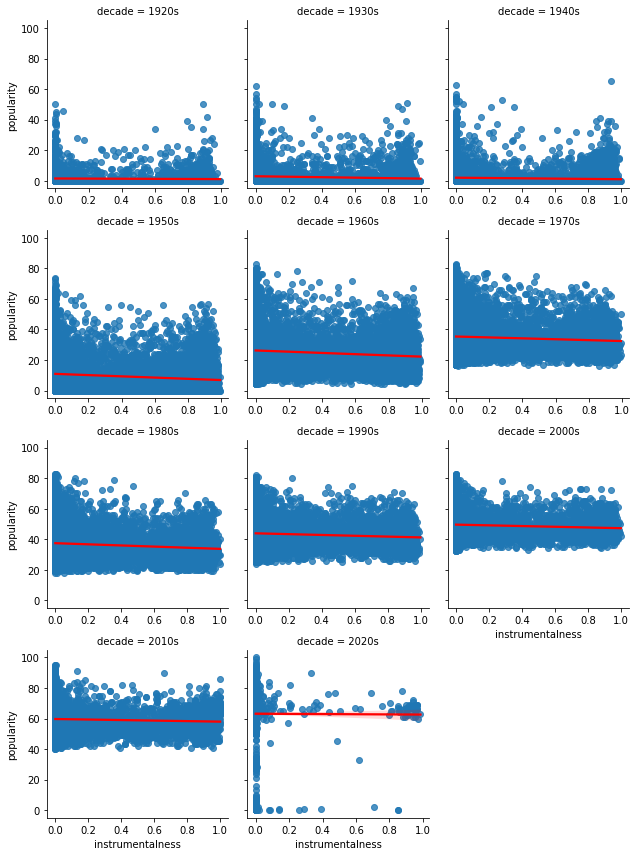

In [114]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'instrumentalness', "popularity", line_kws = {'color':'red'})

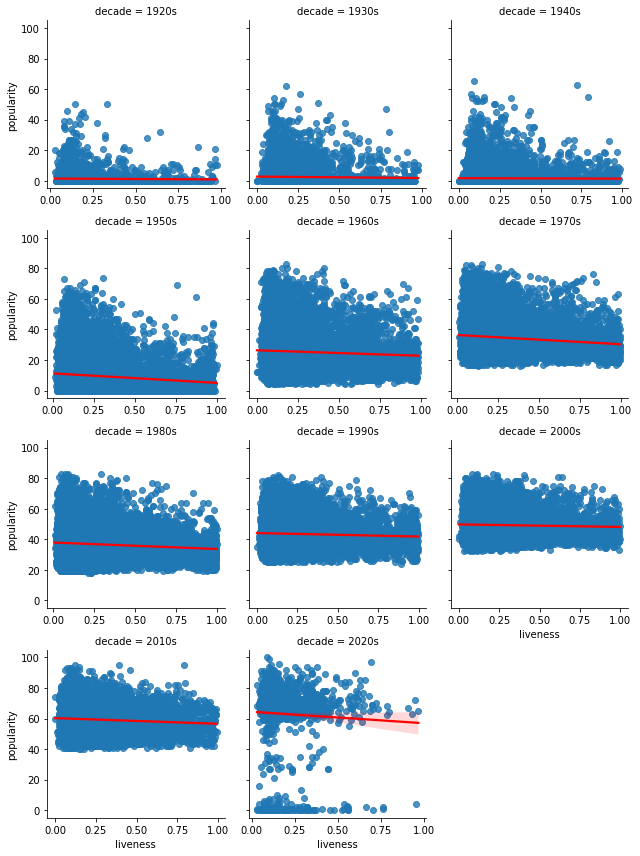

In [36]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'liveness', "popularity", line_kws = {'color':'red'})

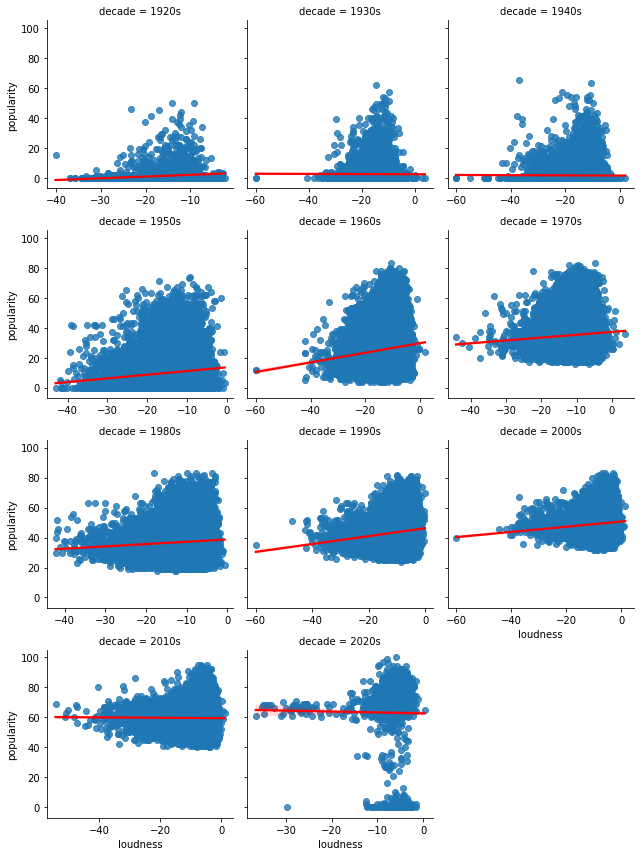

In [477]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'loudness', "popularity", line_kws = {'color':'red'})

Positive relationship between loudness and popularity in many decades is observed (even when ignoring the leverage points)

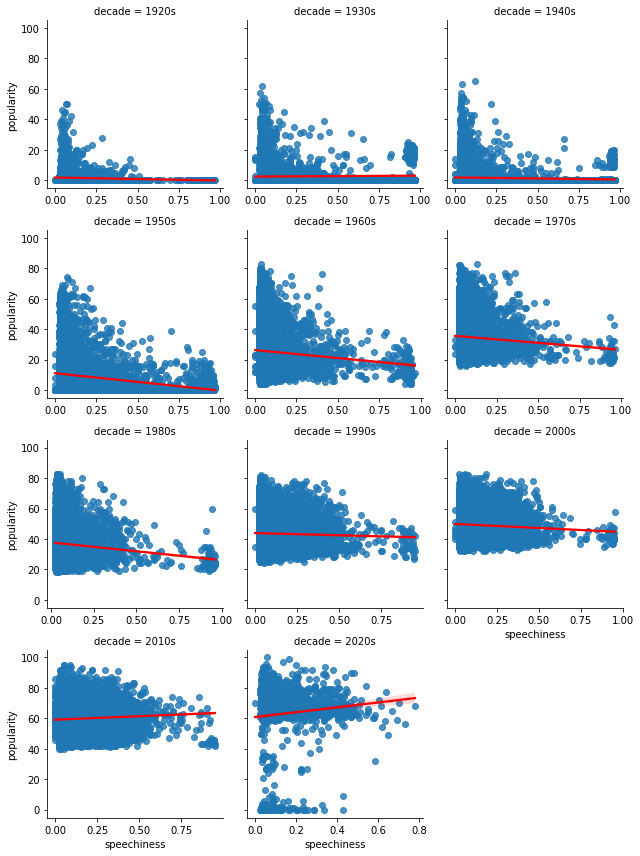

In [115]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'speechiness', "popularity", line_kws = {'color':'red'})

Negative relationship between speechiness and popularity observed in some of the mid to older decades (50s-80s)

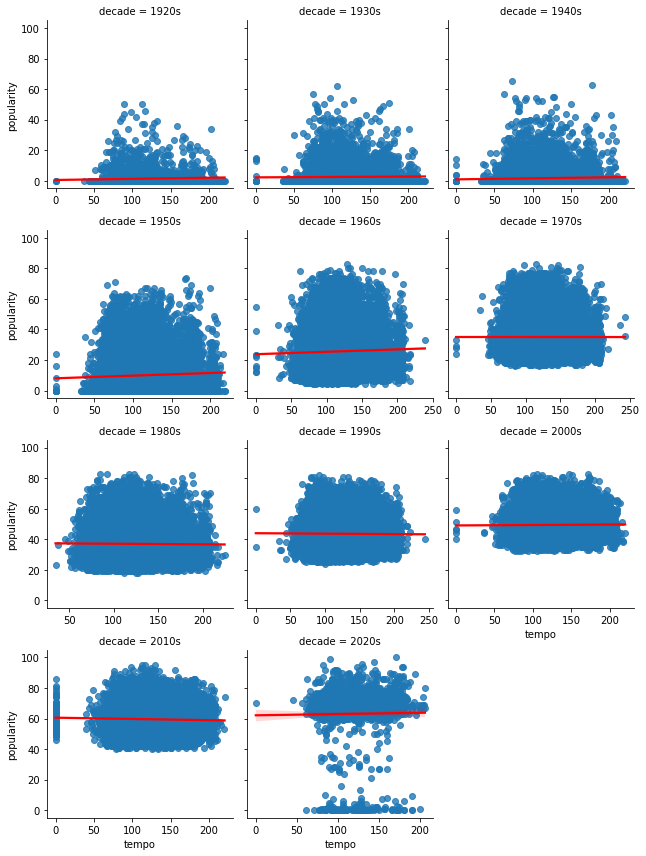

In [474]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'tempo', "popularity", line_kws = {'color':'red'})

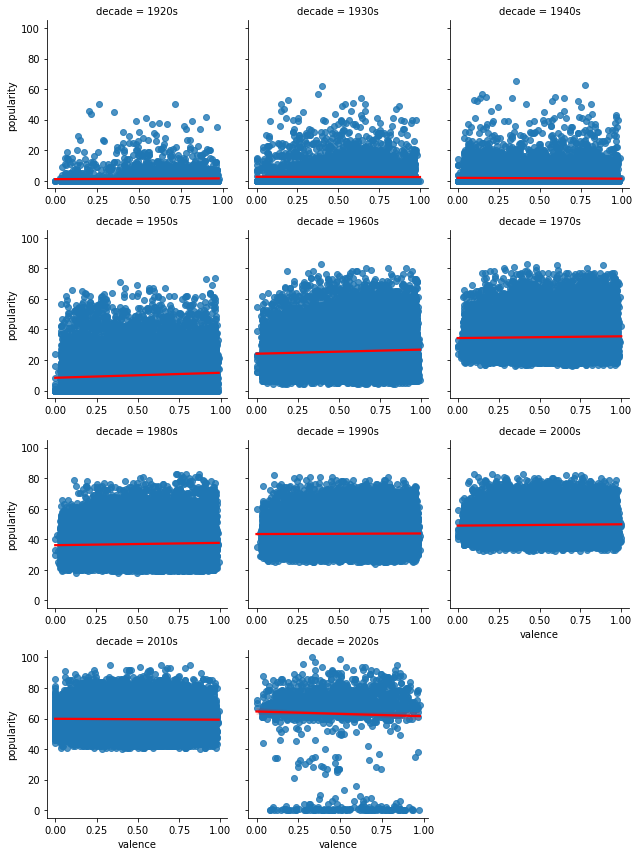

In [475]:
g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, 'valence', "popularity", line_kws = {'color':'red'})

#### Decade-wise line plots of popularity relationships

In [54]:
relplot_data = spotify_data.copy()

In [55]:
round_dict = {col:2 for col in metric_cols}
round_dict['tempo'] = 0
round_dict['loudness'] = 1

Creating "bins" for relplot data so it is not averaging the y over too precise of an x

In [56]:
relplot_data = relplot_data.round(round_dict)

Data not great at being predictive, makes EDA not very interpretable

In [68]:
#g = sns.FacetGrid(spotify_data, col_wrap = 3, sharex = False, col = "decade")
#g.map(sns.relplot, 'acousticness', "popularity", kind="line")

In [82]:
metric_cols

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [108]:
def relplots_subplot():
  figure = plt.figure(figsize=(16,16))
  #fig, axs = plt.subplots(3,3, figsize=(16, 16))

  plotted = 1
  for col in metric_cols:    
    #sns.relplot(data=relplot_data, x = col, y = "popularity", kind="line", ax = ax)
    plt.subplot(3,3,plotted)
    sns.lineplot(data=relplot_data, x = col, y = "popularity")
    plt.title(f'Line plot of Binned {col} with Popularity')
    plotted += 1
  
  figure.tight_layout()
  plt.show()

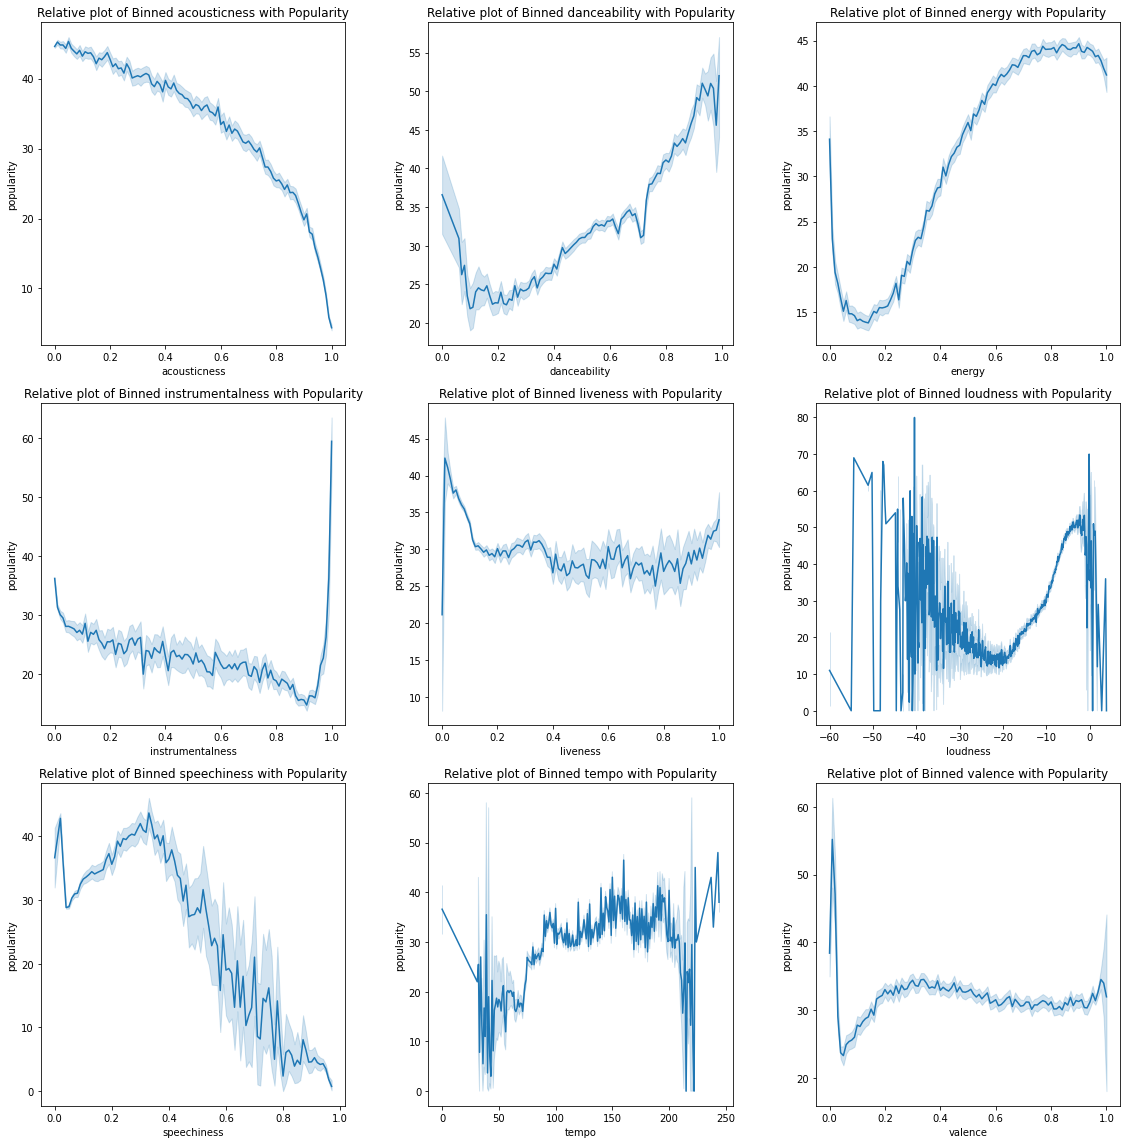

In [109]:
relplots_subplot()

#### Decade-wise plots of binned column relationships with popularity

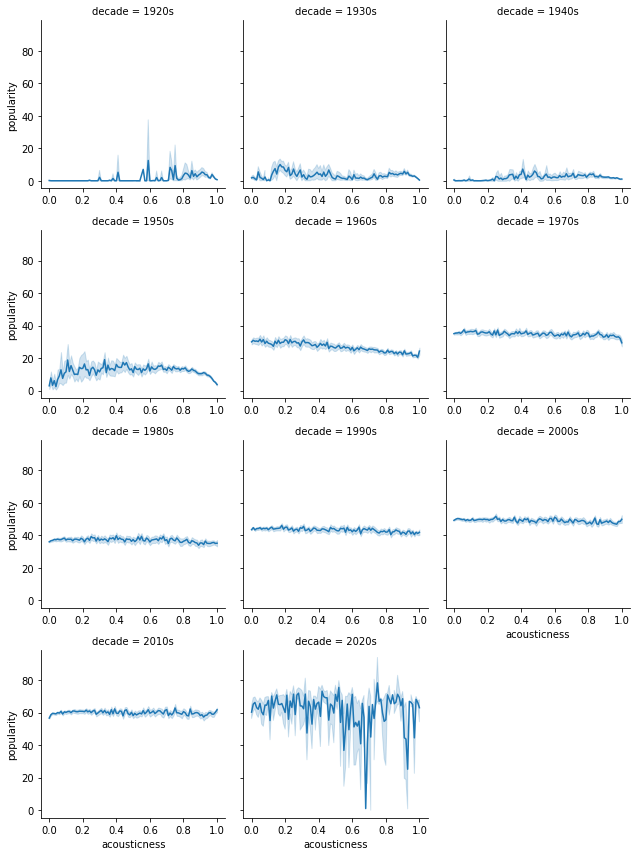

In [111]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'acousticness', "popularity")

In [ ]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'danceability', "popularity")

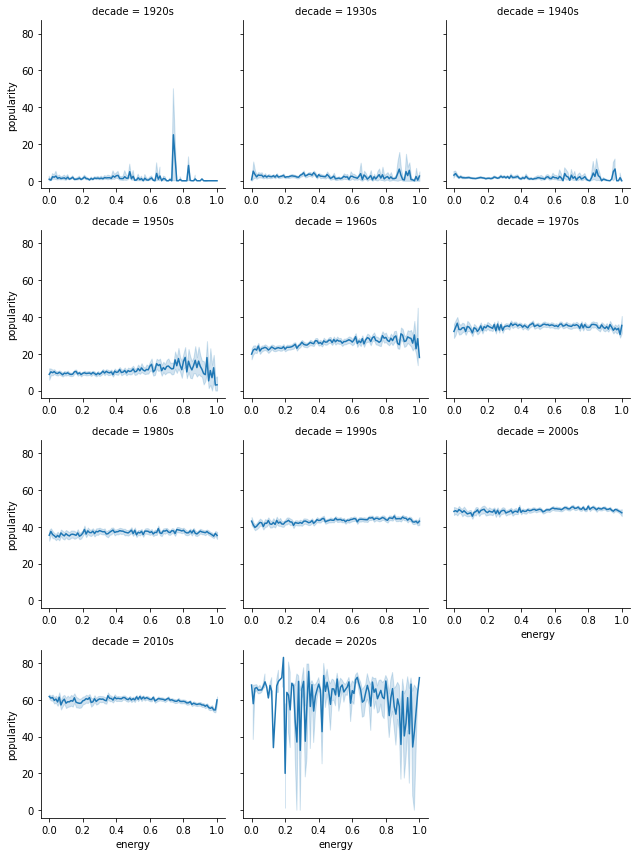

In [120]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'energy', "popularity")

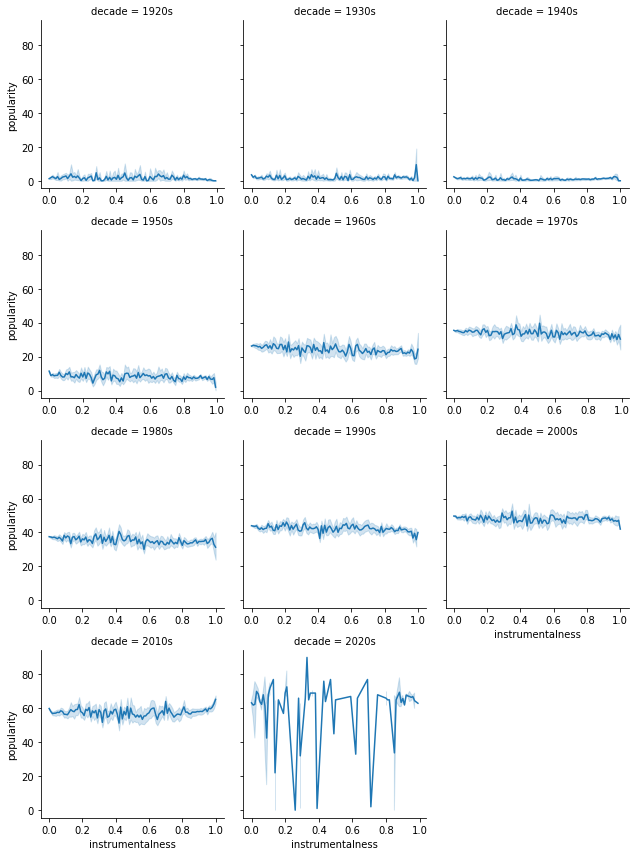

In [121]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'instrumentalness', "popularity")

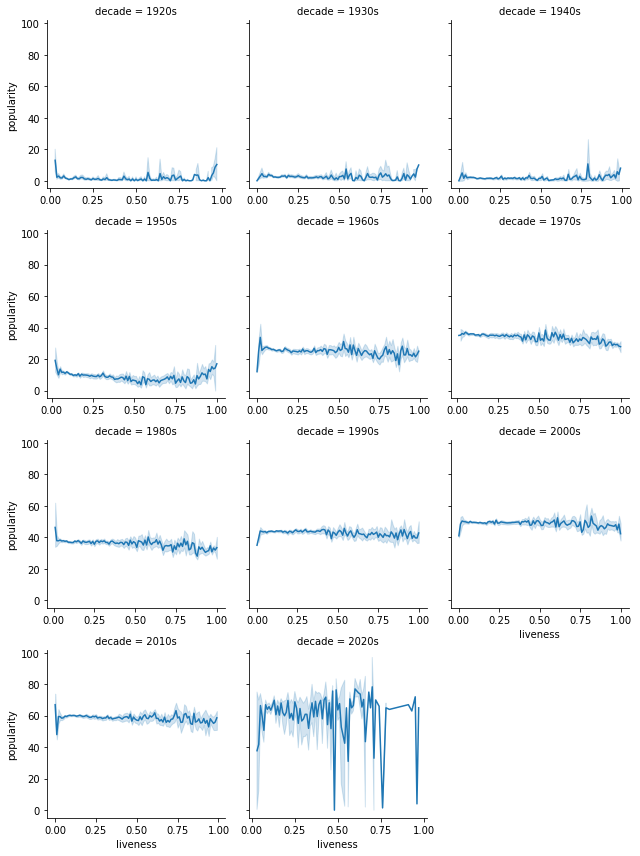

In [122]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'liveness', "popularity")

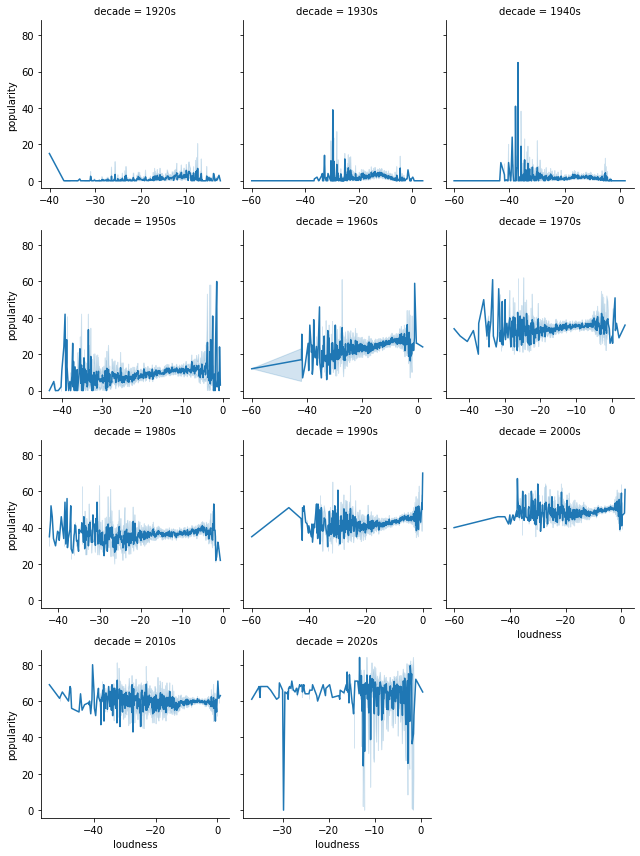

In [123]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'loudness', "popularity")

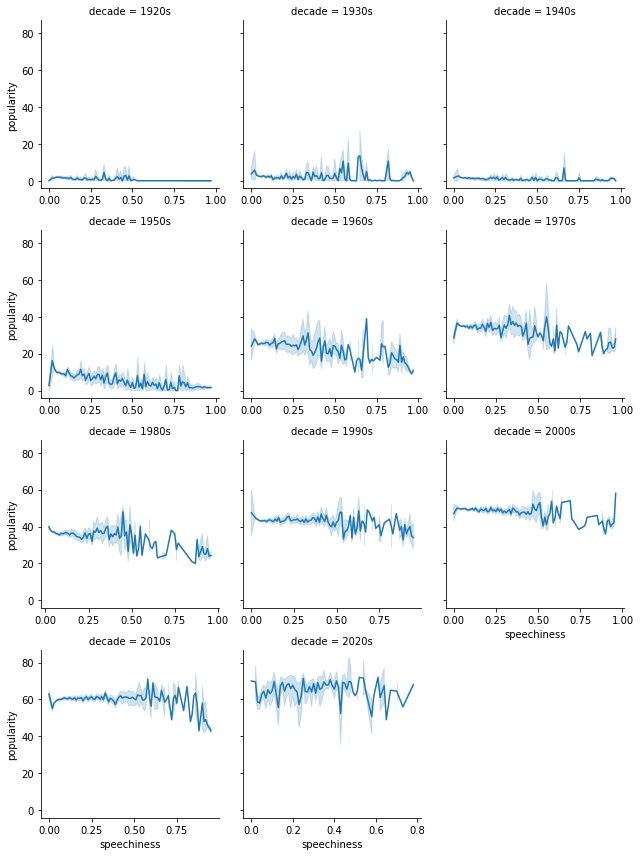

In [124]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'speechiness', "popularity")

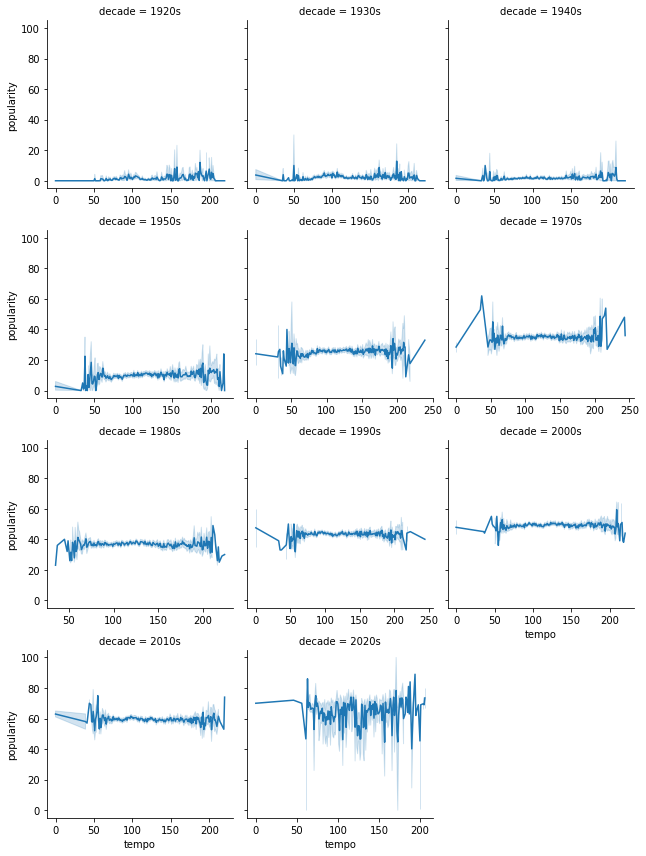

In [125]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'tempo', "popularity")

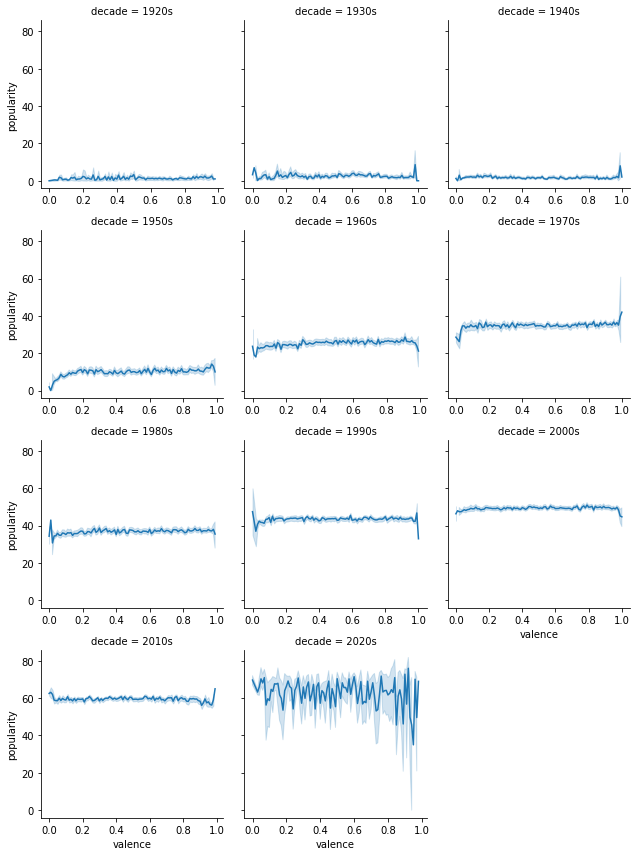

In [126]:
g = sns.FacetGrid(relplot_data, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.lineplot, 'valence', "popularity")

### Feature Selection

In [21]:
corr_table = X_unscaled_all_interactions.corr()['popularity'].sort_values(key=abs, ascending = False)[1:]
pd.DataFrame(corr_table)[:15]

popularity
acousticness                -0.593345
energy                       0.497488
loudness                     0.466546
danceability decade_2010s    0.459437
tempo decade_2010s           0.455195
energy decade_2010s          0.438103
acousticness decade_1940s   -0.415330
valence decade_2010s         0.411938
tempo decade_1940s          -0.410924
danceability decade_1940s   -0.401696
loudness decade_1940s        0.400164
loudness decade_2010s       -0.391430
valence decade_1940s        -0.371414
acousticness decade_1950s   -0.363151
energy decade_1940s         -0.352126

It is important to isolate the feature from the interaction in viewing this plot. In many cases, the relationship between the feature and popularity is greater than the association between the interaction. This suggests that passing in the feature may be more ideal, and that passing in the extra information of the decade does not improve the model

In [22]:
X_unscaled_no_popularity = X_unscaled_all.drop(['popularity'], axis = 1)
X_unscaled_inter_no_popularity = X_unscaled_all_interactions.drop(['popularity'], axis = 1)

In [23]:
sc0 = StandardScaler()
X_scaled_all = pd.DataFrame(sc0.fit_transform(X_unscaled_no_popularity), index=X_unscaled_no_popularity.index, columns=X_unscaled_no_popularity.columns)
y = spotify_data_with_dummies['popularity']

In [24]:
sc1 = StandardScaler()
X_scaled_all_interactions = pd.DataFrame(sc1.fit_transform(X_unscaled_inter_no_popularity), index=X_unscaled_inter_no_popularity.index, columns=X_unscaled_inter_no_popularity.columns)

In [25]:
pca1 = PCA(n_components=len(X_scaled_all.columns))
latent_vars = pca1.fit_transform(X_scaled_all)

In [26]:
print ("Variance explained by each latent variable in PCA: ", pca1.explained_variance_ratio_)
print("\n")

Variance explained by each latent variable in PCA:  [0.24396335 0.12075394 0.10462157 0.08616502 0.07804635 0.07155306
 0.06859278 0.06442256 0.05751638 0.03956368 0.02971379 0.02569044
 0.00939707]




In [27]:
#Better way of attributing how much a latent dimension attributes for variance

latent_data = [X_scaled_all.columns]

for j in range(0,3):
    latent_data.append(np.round(pca1.components_[j],4))

latent_df = pd.DataFrame(np.array(latent_data).T, columns = ['Column', 'Latent Dim1', 'Latent Dim2', 'Latent Dim3'])

In [28]:
latent_df.sort_values(by='Latent Dim1', key=abs, ascending=False)

Column Latent Dim1 Latent Dim2 Latent Dim3
3             energy     -0.4747      0.2646       0.125
8           loudness     -0.4609      0.2325      0.0258
0       acousticness      0.4381     -0.1464     -0.2297
5   instrumentalness      0.3146      0.0755      0.0245
1       danceability      -0.314     -0.3817     -0.3208
12           valence     -0.3073     -0.1382     -0.4927
4           explicit     -0.1849     -0.4513      0.3814
11             tempo     -0.1812      0.1931     -0.0357
10       speechiness     -0.0758     -0.6029      0.2753
2        duration_ms      0.0459      0.2581      0.4336
7           liveness     -0.0436     -0.0172      0.3458
9               mode      0.0282      0.1051     -0.2276
6                key     -0.0281     -0.0397      0.0528

In looking at the latent dimensions of a principal components analysis, we are looking at the dimensions that account for the most variance in the dataset (in an unsupervised setting). The first dimension consists strongly of energy, loudness, and acousticness, suggesting there may be some association between these variables. It is important to note sources of relationships between variables or collinearity before going further in the modeling process (even if it turns out that these variables are used together).

In [161]:
rfe_selector = RFE(estimator=LinearRegression(),n_features_to_select = 10, step = 1)
rfe_selector.fit(X_scaled_all, y)
rfe_cols = list(X_scaled_all.columns[rfe_selector.get_support()])

rfe_cols

['acousticness',
 'danceability',
 'energy',
 'explicit',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [48]:
rfe_inter_selector = RFE(estimator=LinearRegression(),n_features_to_select = 30, step = 1)
rfe_inter_selector.fit(X_scaled_all_interactions, y)
rfe_inter_cols = list(X_scaled_all_interactions.columns[rfe_inter_selector.get_support()])

rfe_inter_cols

['loudness',
 'liveness decade_1930s',
 'liveness decade_1940s',
 'liveness decade_1950s',
 'loudness decade_1920s',
 'loudness decade_1930s',
 'loudness decade_1940s',
 'loudness decade_1950s',
 'loudness decade_1960s',
 'loudness decade_1970s',
 'loudness decade_1980s',
 'loudness decade_1990s',
 'loudness decade_2000s',
 'loudness decade_2010s',
 'loudness decade_2020s',
 'tempo decade_1920s',
 'tempo decade_1930s',
 'tempo decade_1940s',
 'tempo decade_1950s',
 'tempo decade_1960s',
 'tempo decade_1990s',
 'tempo decade_2000s',
 'tempo decade_2010s',
 'tempo decade_2020s',
 'valence decade_1920s',
 'valence decade_1930s',
 'valence decade_1940s',
 'valence decade_1950s',
 'valence decade_2000s',
 'valence decade_2010s']

Recursive feature elimination is used to determine the best features for a predictive model. While this is not perfect by any means, it is an effective way of reducing variables down to a small, effective size. It appears that liveness, loudness, tempo, and valence have the largest associations, which is consistent with our EDA.

In [49]:
model_cols = rfe_inter_cols.copy()

In [50]:
X_unscaled_all_interactions[model_cols].corr()

loudness  liveness decade_1930s  liveness decade_1940s  \
loudness               1.000000              -0.077358              -0.151798   
liveness decade_1930s -0.077358               1.000000              -0.046119   
liveness decade_1940s -0.151798              -0.046119               1.000000   
liveness decade_1950s -0.152686              -0.052826              -0.067337   
loudness decade_1920s  0.181594               0.029571               0.037695   
loudness decade_1930s  0.168433              -0.744064               0.053657   
loudness decade_1940s  0.321221               0.054948              -0.697634   
loudness decade_1950s  0.324068               0.064645               0.082403   
loudness decade_1960s  0.197020               0.064151               0.081773   
loudness decade_1970s  0.092918               0.064725               0.082504   
loudness decade_1980s  0.113057               0.062849               0.080114   
loudness decade_1990s  0.040557               0.061998               0.079029   
loudness decade_2000s -0.079662               0.058888               0.075064   
loudness decade_2010s -0.051852               0.057296               0.073035   
loudness decade_2020s -0.021650               0.016510               0.021045   
tempo decade_1920s    -0.125316              -0.030005              -0.038248   
tempo decade_1930s    -0.096092               0.775340              -0.054811   
tempo decade_1940s    -0.203465              -0.056517               0.748868   
tempo decade_1950s    -0.195844              -0.066435              -0.084685   
tempo decade_1960s    -0.072252              -0.067012              -0.085420   
tempo decade_1990s     0.104025              -0.066974              -0.085372   
tempo decade_2000s     0.261016              -0.067024              -0.085435   
tempo decade_2010s     0.264776              -0.066877              -0.085248   
tempo decade_2020s     0.076089              -0.018852              -0.024030   
valence decade_1920s  -0.103573              -0.028444              -0.036257   
valence decade_1930s  -0.071358               0.745828              -0.052184   
valence decade_1940s  -0.120366              -0.050827               0.697415   
valence decade_1950s  -0.113900              -0.059171              -0.075424   
valence decade_2000s   0.266173              -0.061913              -0.078920   
valence decade_2010s   0.277269              -0.060546              -0.077178   

                       liveness decade_1950s  loudness decade_1920s  \
loudness                           -0.152686               0.181594   
liveness decade_1930s              -0.052826               0.029571   
liveness decade_1940s              -0.067337               0.037695   
liveness decade_1950s               1.000000               0.043176   
loudness decade_1920s               0.043176               1.000000   
loudness decade_1930s               0.061459              -0.034404   
loudness decade_1940s               0.080227              -0.044911   
loudness decade_1950s              -0.692825              -0.052836   
loudness decade_1960s               0.093664              -0.052432   
loudness decade_1970s               0.094502              -0.052901   
loudness decade_1980s               0.091763              -0.051368   
loudness decade_1990s               0.090521              -0.050673   
loudness decade_2000s               0.085979              -0.048130   
loudness decade_2010s               0.083655              -0.046830   
loudness decade_2020s               0.024106              -0.013494   
tempo decade_1920s                 -0.043809              -0.892357   
tempo decade_1930s                 -0.062781               0.035144   
tempo decade_1940s                 -0.082518               0.046193   
tempo decade_1950s                  0.731980               0.054299   
tempo decade_1960s                 -0.097842               0.054771   
tempo decade_1990s  

In looking at this table, there is definitely collinearity, however, many of these variables are "switched" off when another is active, due to the fact that they are interaction variables from different decades, meaning only one interaction variable for a given song metric will be used for a given decade. One can think of this as a linear model being set up for each decade, by use of these different interaction variables.

In [51]:
interesting_cols = ['year', 'popularity']

In [52]:
for interesting_col in interesting_cols:
  X_unscaled_all_interactions[interesting_col] = spotify_data_with_dummies[interesting_col]

In [53]:
interesting_cols.append('decade')

In [54]:
X_unscaled_all_interactions['decade'] = spotify_data['decade']

In [55]:
X_final_cols_unscaled = X_unscaled_all_interactions.copy()

### Train/Test Split

In [56]:
X_train_pd, X_val_pd, y_train, y_val = train_test_split(X_final_cols_unscaled, y, test_size = 0.25, random_state = 0)

In [57]:
# Scale whole matrix of features to prevent information leakage
# Scale for training set and validation set
sc2 = StandardScaler()
X_train = sc2.fit_transform(X_train_pd[model_cols])
X_val = sc2.transform(X_val_pd[model_cols])

In [116]:
# Scale for training set and validation set
sc4 = StandardScaler()
X_train_simple = sc4.fit_transform(X_train_pd[metric_cols])
X_val_simple = sc4.transform(X_val_pd[metric_cols])

### Simple Model (no interactions)

In [117]:
# Fit a classifier with parameters found above
lin_regressor_simple = LinearRegression()
lin_regressor_simple.fit(X_train_simple, y_train)

LinearRegression()

In [118]:
for coef, col in zip(lin_regressor_simple.coef_, metric_cols):
  print(f"{col}: {coef}")

acousticness: -8.70890032844128
danceability: 4.725511699386118
energy: 3.0230875281940155
instrumentalness: -2.1648771721870097
liveness: -1.3400239544709236
loudness: 1.8206445604067238
speechiness: -3.870777766773358
tempo: 0.7732670288440187
valence: -5.992685131340313


In [119]:
# Predict both class and probability for the training set 
y_train_pred_simple = lin_regressor_simple.predict(X_train_simple)

# Predict both class and probability for the test set 
y_val_pred_simple = lin_regressor_simple.predict(X_val_simple)

In [121]:
X_train_pd['simple_pred'] = y_train_pred_simple
X_val_pd['simple_pred'] = y_val_pred_simple

#### Analysis of Fit on Train

In [122]:
print(f"RMSE score train: {mean_squared_error(y_train, y_train_pred_simple)}")
print(f"R^2 score train: {r2_score(y_train, y_train_pred_simple)}")

RMSE score train: 251.5287560382064
R^2 score train: 0.458596346799527


In [ ]:
a, b = np.polyfit(X_train_pd['simple_pred'], X_train_pd['popularity'], 1)

(0.0, 100.0)

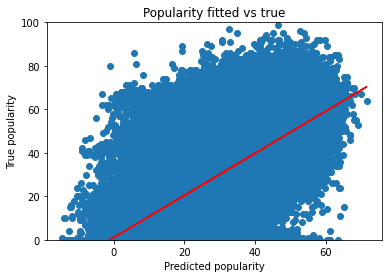

In [123]:
plt.scatter(X_train_pd['simple_pred'], X_train_pd['popularity'])
plt.plot(X_train_pd['simple_pred'], a * X_train_pd['simple_pred'] + b, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

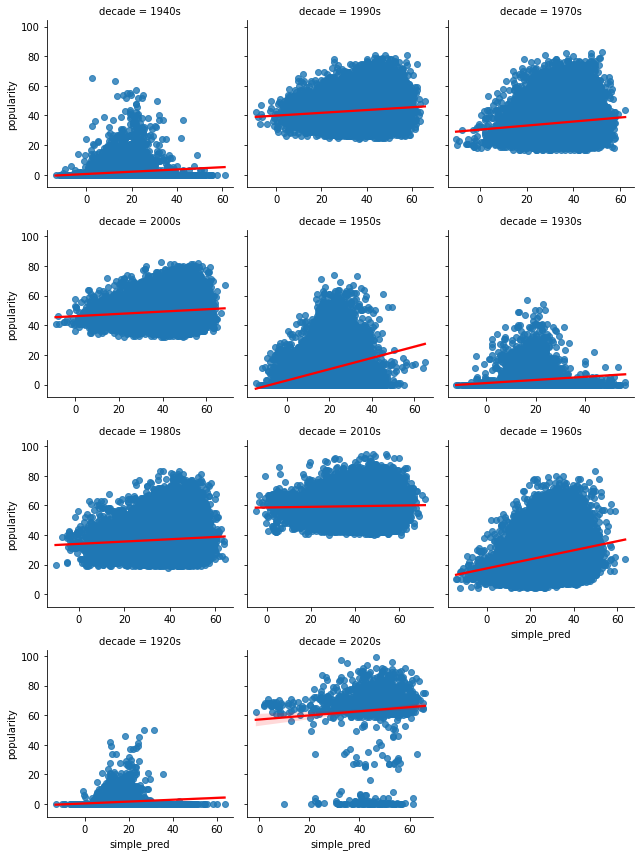

In [124]:
g = sns.FacetGrid(X_train_pd, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, "simple_pred", "popularity", line_kws = {'color':'red'})

It seems as though different relationships between the target and a metric over different decades led to an "averaging" effect over coefficients not allowing any of the relationships to be learned. Thus, this could be benefited by including interaction effects by decade for more nuanced relatipnships between metrics and popularity scores.

#### Analysis of Fit on Val

In [129]:
print(f"RMSE score val: {mean_squared_error(y_val, y_val_pred_simple)}")
print(f"R^2 score val: {r2_score(y_val, y_val_pred_simple)}")

RMSE score val: 253.76717755170372
R^2 score val: 0.4594513660578803


In [130]:
a_val, b_val = np.polyfit(X_val_pd['simple_pred'], X_val_pd['popularity'], 1)

(0.0, 100.0)

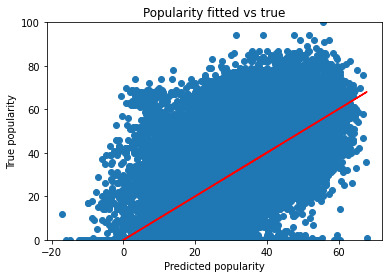

In [131]:
plt.scatter(X_val_pd['simple_pred'], X_val_pd['popularity'])
plt.plot(X_val_pd['simple_pred'], a_val * X_val_pd['simple_pred'] + b_val, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

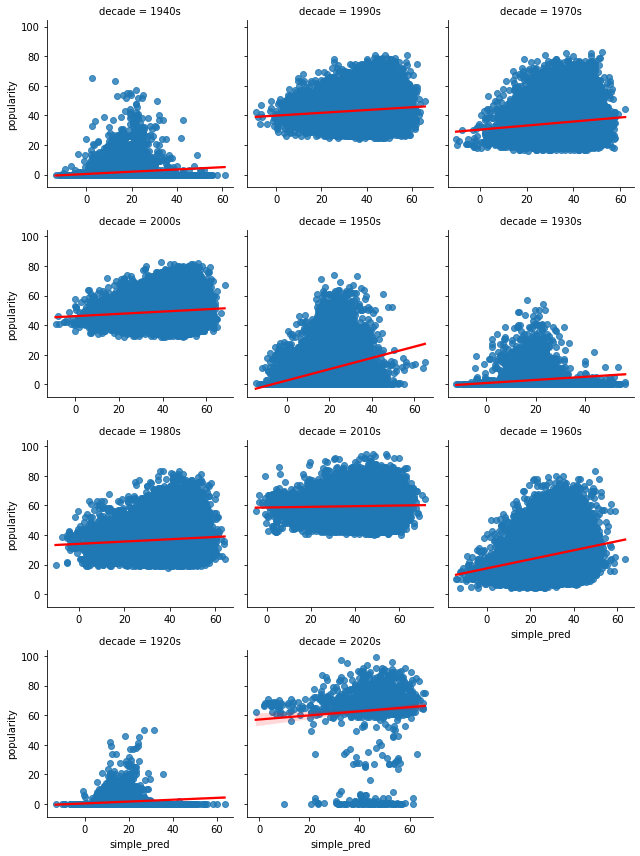

In [132]:
g = sns.FacetGrid(X_train_pd, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, "simple_pred", "popularity", line_kws = {'color':'red'})

I hypothesize that the model is underfit

### Modeling with a Temporal Component

In [133]:
# Fit a classifier with parameters found above
lin_regressor = LinearRegression()
lin_regressor.fit(X_train, y_train)

LinearRegression()

In [134]:
for coef, col in zip(lin_regressor.coef_, model_cols):
  print(f"{col}: {coef}")

loudness: 1.955019764713686
liveness decade_1930s: -0.7365795509716904
liveness decade_1940s: -0.8330378819254411
liveness decade_1950s: -1.1160949945848566
loudness decade_1920s: 1.653104295372457
loudness decade_1930s: 1.7785506336976447
loudness decade_1940s: 2.468405932240749
loudness decade_1950s: 2.4906150362532293
loudness decade_1960s: 0.7324174939096625
loudness decade_1970s: -0.9017162603079788
loudness decade_1980s: -1.5031282035185953
loudness decade_1990s: -1.2358471318714634
loudness decade_2000s: -1.518849246918148
loudness decade_2010s: -2.76271164629178
loudness decade_2020s: -0.8417724430242697
tempo decade_1920s: -1.9963257698227217
tempo decade_1930s: -2.6059709982508203
tempo decade_1940s: -3.3781652112909732
tempo decade_1950s: -2.683114942238923
tempo decade_1960s: -1.3043675883530166
tempo decade_1990s: 2.2889791360769687
tempo decade_2000s: 2.7200342426489135
tempo decade_2010s: 4.527613081101399
tempo decade_2020s: 2.2093543680604357
valence decade_1920s: -1.1

The model was able to learn from these features and learned different associations by decade, as shown by the change in sign for valence between earlier songs and more recent songs, as well as similar trends being seen for loudness and liveness. Different decades had different signs in their relation with the target variable. However, that being said, there is likely some collinearity between song metrics themselves, such that this could confound some of the sign switches in the coefficients.

In [135]:
# Predict both class and probability for the training set 
y_train_pred = lin_regressor.predict(X_train)

# Predict both class and probability for the test set 
y_val_pred = lin_regressor.predict(X_val)

In [136]:
X_train_pd['pred'] = y_train_pred
X_val_pd['pred'] = y_val_pred

In [61]:
X_train_pd['pred'] 

724       -0.033742
94924     42.124325
66065     33.504859
14854     46.486826
46826     49.371208
            ...    
97639     60.901769
95939     48.002215
152315    59.446199
117952     1.692481
43567     34.982841
Name: pred, Length: 127431, dtype: float64

#### Analysis of Fit on Train

In [62]:
print(f"RMSE score train: {mean_squared_error(y_train, y_train_pred)}")
print(f"R^2 score train: {r2_score(y_train, y_train_pred)}")

RMSE score train: 109.02166043352437
R^2 score train: 0.7653360746247005


In [63]:
a, b = np.polyfit(X_train_pd['pred'], X_train_pd['popularity'], 1)

(0.0, 100.0)

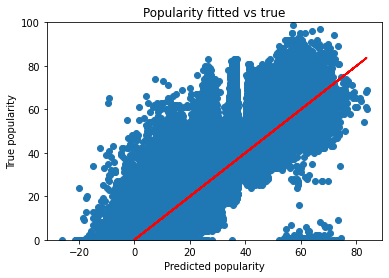

In [64]:
plt.scatter(X_train_pd['pred'], X_train_pd['popularity'])
plt.plot(X_train_pd['pred'], a * X_train_pd['pred'] + b, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

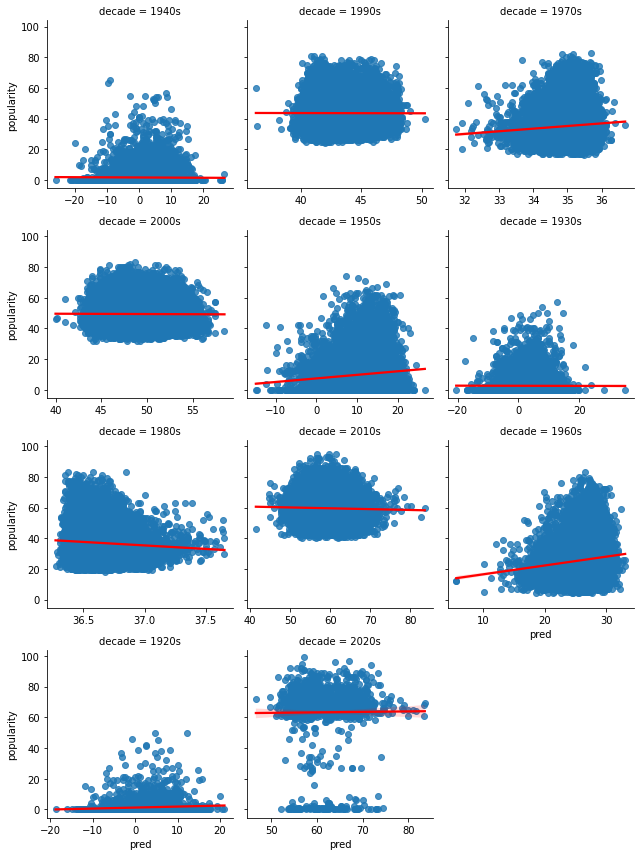

In [65]:
g = sns.FacetGrid(X_train_pd, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, "pred", "popularity", line_kws = {'color':'red'})

It seems as though different relationships between the target and a metric over different decades led to an "averaging" effect over coefficients not allowing any of the relationships to be learned. Thus, this could be benefited by including interaction effects by decade for more nuanced relatipnships between metrics and popularity scores.

#### Analysis of Fit on Validation

In [137]:
print(f"RMSE score val: {mean_squared_error(y_val, y_val_pred)}")
print(f"R^2 score val: {r2_score(y_val, y_val_pred)}")

RMSE score val: 110.30700501688433
R^2 score val: 0.7650354098138841


In [138]:
a_val, b_val = np.polyfit(X_val_pd['pred'], X_val_pd['popularity'], 1)

(0.0, 100.0)

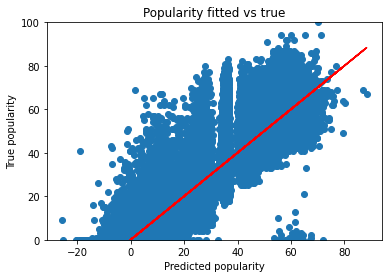

In [139]:
plt.scatter(X_val_pd['pred'], X_val_pd['popularity'])
plt.plot(X_val_pd['pred'], a_val * X_val_pd['pred'] + b_val, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

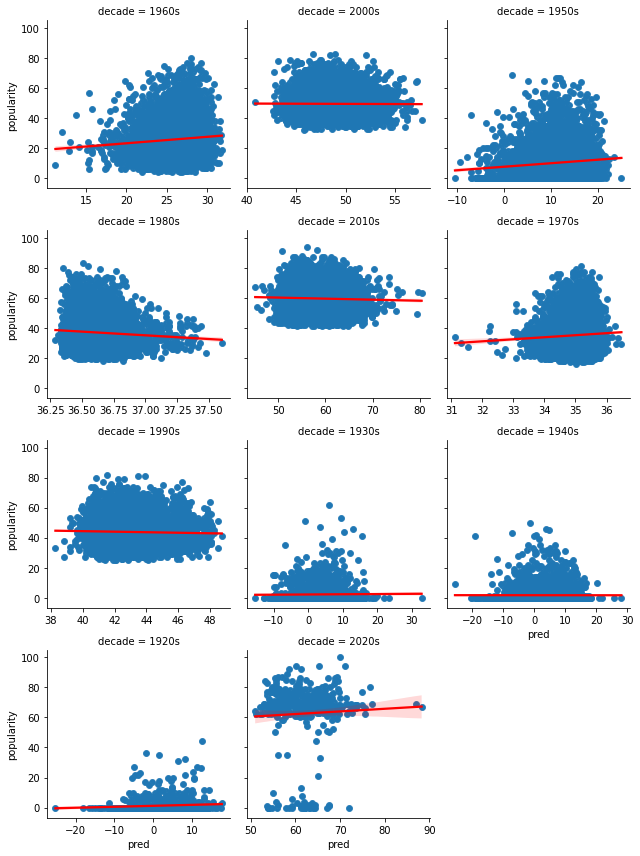

In [140]:
g = sns.FacetGrid(X_val_pd, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.scatterplot, "pred", "popularity")
g.map(sns.regplot, "pred", "popularity", line_kws = {'color':'red'})

### Exploration of Change Point Detection

Ultimately, due to a time constraint change point detection was not able to be tested for the model. This may have proved beneficial, as the decade splits created a sparser data set with many features to learn. Finding the change points for each variable in their relations with popularity would have created a model that was more precise in terms of its engineered features, and would have allowed it to better learn the 'eras' of music.

### Final Thoughts on the Data

It is clear from the scatter plots that the data here has high variance- songs with very similar song metrics can and often will have widely different popularities. This is ultimately because the data itself is not nuanced enough to produce a truly great predictor of a song's popularity.

In thinking about what goes into a popular song nowadays, while there are absolutely trends in how songs are made, this will not be able to solely tell you the popularity. There is so much music nowadays that most music with any combination of song metrics will not have a high popularity, since it is challenging to break the glass ceiling. 

Furthermore, more data is definitely required to truly predict a song's popularity score. For example, two artists (e.g. Kendrick Lamar and Billy Joel)releasing songs with the same song metrics will lead to wildly different results. There are many factors that go into songs making the charts nowadays, including how famous an artist already is, its use in social media/pop culture leading to it trending, as well as other factors that make people like a given song. Additionally, data about what niche the artist/its fans fall into could be helpful to know how a song and its given metrics falls into a niche. While this would be helpful, it is still really challenging to create a model that will predict any kind of break through from a small artist, given data on fame. However, one can make a model that ranks songs well in terms of their ability to become popular, given a bunch of small artists, which seems like a great use case of this kind of song data.

Ultimately, music is quite hard to quantify, and more data is required to truly determine what will make people like and listen to songs. 

### Extra: Attempt to Model the Data Better with Neural Networks

Here, we explore Neural Networks to create an uninterpretable, but perhaps better predictive model for the data. There is a lot of data, such that neural networks may train better in this setting. Furthermore, neural networks can learn complex relationships, interactions, and dependencies between variables, helping reduce the need for manual feature engineering and feature selection.

While LSTMs are often used do the sequential nature of Recurrent Neural Networks and the LSTMs ability to use memory and forget gates to keep and drop important information, the data we have is time series but not sequential, as the observations are generally independent of each other, but rather the observations and their co-variates/popularity scorres are just not independent from time/era. 

Thus, we use an Artificial Neural Network with a ReLU final activation function. In doing so, we bring a longer training and inference time, and the potential of overfitting. Additionally, we do not have the time to truly tune the neural network in terms of its architecture, dropout rate, regularization, optimizer, etc. Meanwhile, a Linear Regression can easily be tuned (for parameters like L1/L2 penalties and such) with a Grid Search in minutes. Finally, with the neural network, we lose interpretability in favor of predictive accuracy.

In [85]:
#NN- Sequence of layers
from keras.models import Sequential
#Dense- output layer
from keras.layers import Dense
#LSTM layers
from keras.layers import LSTM
#Dropout for regularization (prevent overfitting)
from keras.layers import Dropout
import tensorflow as tf

In [86]:
nn_cols = list(spotify_data.columns)
bad_cols = ['id', 'release_date', 'name', 'artists', 'decade', 'popularity']

for col in bad_cols:
  nn_cols.remove(col)

Here, I split the training set further, into a true validation set, so the other holdout set of calidation data can be used as a test data. This is because I want to tune my model, but also want an objective test set to evaluate my performance on (same set as linear regression). In tuning the model, I use early stopping, which uses validation performance to determine which epoch of the model is best. Using the other validation set would be cheating and a form of data leakage, leading to high performance.

In [87]:
X_true_train_pd, X_val_tune_pd, y_true_train, y_val_tune = train_test_split(X_train_pd, y_train, test_size = 0.1, random_state = 0)

In [88]:
# Scale whole matrix of features to prevent information leakage
# Scale for training set and validation set
sc3 = StandardScaler()
X_train_nn = sc3.fit_transform(X_true_train_pd[nn_cols])
X_val_nn = sc3.transform(X_val_tune_pd[nn_cols])
X_test_nn = sc3.transform(X_val_pd[nn_cols])

In [89]:
# #Predicting continuous output- regression
# regressor = Sequential()
# #First LSTM layers
# #units - LSTM cells/mem units (increase dimensionality)
# #return_sequences - true as stacked LSTM (several layers,false (default) only once there is no layer after)
# #input_shape - shape of input containing x train (timesteps, indicators)- first dim already taken into account
# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# #Classic number to use- 20% of neurons ignored in training (10 neurons)
# regressor.add(Dropout(0.2))
# #Input shape does not need to be specified as recognized due to units
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# #Last layer- return sequences is false
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))
# #1 output- stock price
# regressor.add(Dense(units = 1))

In [90]:
def create_model(input_shape, metrics, optimizer, loss_function, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(input_shape = (input_shape, ), units=200, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=1, activation='relu', bias_initializer = output_bias))
  ann.compile(optimizer = optimizer, loss = loss_function, metrics=metrics)
  return ann

In [91]:
regressor = create_model(input_shape = X_train_nn.shape[1], metrics = ['mse'], optimizer = 'adam', loss_function = 'mse')

In [94]:
EPOCHS = 100
BATCH_SIZE = 32
val_data = (X_val_nn, y_val_tune)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_mse", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [95]:
#Number of times to forward and backpropagate
#100- teacher observed convergence
regressor.fit(X_train_nn, y_true_train, epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks = earlystopping, validation_data = val_data)

Epoch 1/100
3584/3584 [==============================] - 16s 5ms/step - loss: 95.9063 - mse: 95.9063 - val_loss: 82.8820 - val_mse: 82.8820
Epoch 2/100
3584/3584 [==============================] - 14s 4ms/step - loss: 95.5716 - mse: 95.5716 - val_loss: 82.5296 - val_mse: 82.5296
Epoch 3/100
3584/3584 [==============================] - 15s 4ms/step - loss: 95.7997 - mse: 95.7997 - val_loss: 82.4675 - val_mse: 82.4675
Epoch 4/100
3584/3584 [==============================] - 14s 4ms/step - loss: 95.5758 - mse: 95.5758 - val_loss: 83.8152 - val_mse: 83.8152
Epoch 5/100
3584/3584 [==============================] - 14s 4ms/step - loss: 95.6841 - mse: 95.6841 - val_loss: 82.9489 - val_mse: 82.9489
Epoch 6/100
3584/3584 [==============================] - 14s 4ms/step - loss: 95.5875 - mse: 95.5875 - val_loss: 82.3349 - val_mse: 82.3349
Epoch 7/100
3584/3584 [==============================] - 14s 4ms/step - loss: 95.1620 - mse: 95.1620 - val_loss: 82.8437 - val_mse: 82.8437
Epoch 8/100
3584/358

In [98]:
# Predict both class and probability for the training set 
y_train_nn_pred = regressor.predict(X_train_nn)
y_val_tune_nn_pred = regressor.predict(X_val_nn)

# Predict both class and probability for the test set 
y_val_nn_pred = regressor.predict(X_test_nn)

1328/1328 [==============================] - 2s 2ms/step


In [99]:
X_true_train_pd['nn_pred'] = y_train_nn_pred
X_val_tune_pd['nn_pred'] = y_val_tune_nn_pred
X_val_pd['nn_pred'] = y_val_nn_pred

#### Analysis of Fit on Train (training + tuning data)

In [101]:
print(f"RMSE score train: {mean_squared_error(y_true_train, y_train_nn_pred)}")
print(f"R^2 score train: {r2_score(y_true_train, y_train_nn_pred)}")

RMSE score train: 83.05018252324457
R^2 score train: 0.8214223559974899


In [ ]:
a, b = np.polyfit(X_true_train_pd['nn_pred'], X_true_train_pd['popularity'], 1)

(0.0, 100.0)

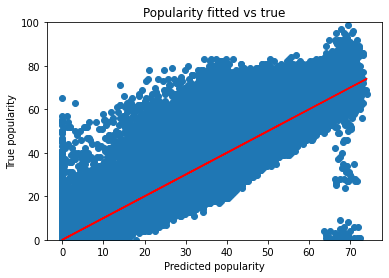

In [102]:
plt.scatter(X_true_train_pd['nn_pred'], X_true_train_pd['popularity'])
plt.plot(X_true_train_pd['nn_pred'], a * X_true_train_pd['nn_pred'] + b, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

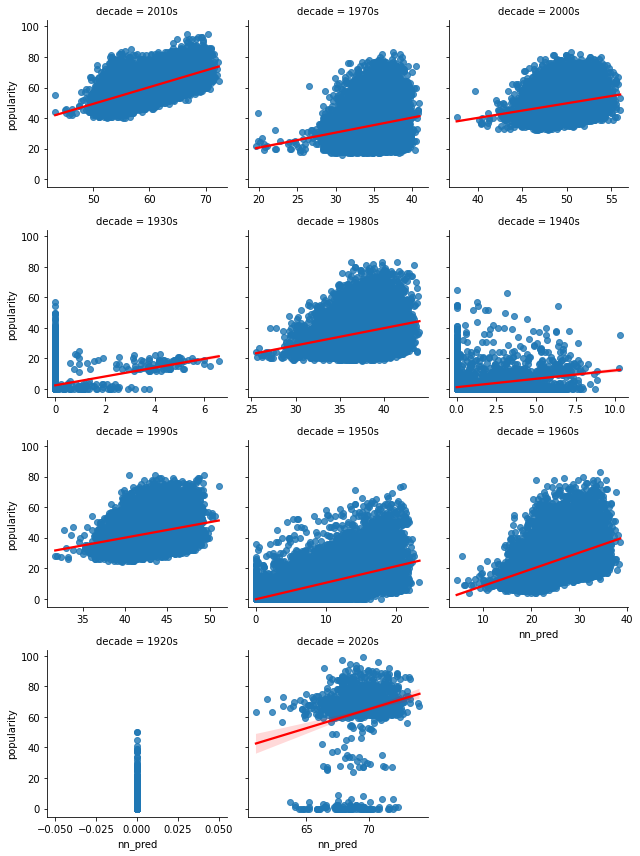

In [103]:
g = sns.FacetGrid(X_true_train_pd, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, "nn_pred", "popularity", line_kws = {'color':'red'})

The models struggles with 1920s and 1930s, even in the training set

In [104]:
print(f"RMSE score train: {mean_squared_error(y_val_tune, y_val_tune_nn_pred)}")
print(f"R^2 score train: {r2_score(y_val_tune, y_val_tune_nn_pred)}")

RMSE score train: 82.33490789768832
R^2 score train: 0.8211174388568983


In [105]:
a, b = np.polyfit(X_val_tune_pd['nn_pred'], X_val_tune_pd['popularity'], 1)

(0.0, 100.0)

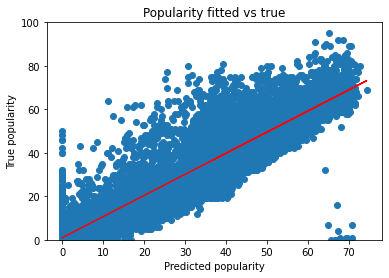

In [106]:
plt.scatter(X_val_tune_pd['nn_pred'], X_val_tune_pd['popularity'])
plt.plot(X_val_tune_pd['nn_pred'], a * X_val_tune_pd['nn_pred'] + b, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

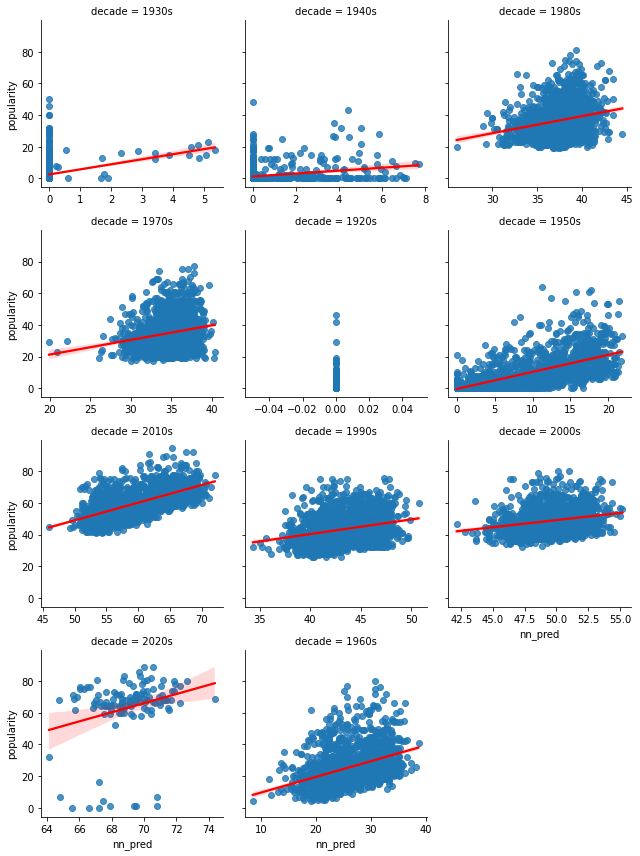

In [107]:
g = sns.FacetGrid(X_val_tune_pd, col_wrap = 3, sharex = False, col = "decade")
g.map(sns.regplot, "nn_pred", "popularity", line_kws = {'color':'red'})

#### Analysis of Fit on Validation (Test)

In [108]:
print(f"RMSE score val: {mean_squared_error(y_val, y_val_nn_pred)}")
print(f"R^2 score val: {r2_score(y_val, y_val_nn_pred)}")

RMSE score val: 84.26029562585006
R^2 score val: 0.8205174201977617


In [109]:
a_val, b_val = np.polyfit(X_val_pd['nn_pred'], X_val_pd['popularity'], 1)

(0.0, 100.0)

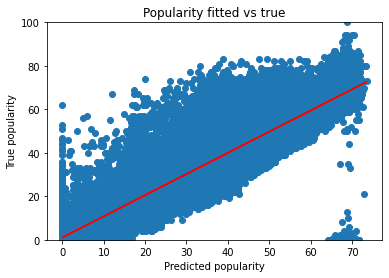

In [110]:
plt.scatter(X_val_pd['nn_pred'], X_val_pd['popularity'])
plt.plot(X_val_pd['nn_pred'], a_val * X_val_pd['nn_pred'] + b_val, color = 'red')
plt.xlabel('Predicted popularity')
plt.ylabel('True popularity')
plt.title('Popularity fitted vs true')
plt.ylim(0, 100)

The Neural Network performs better than the Linear Regression, with its R squared of 0.85 and RMSE of 84.2. The RMSE appears to be high in both the linear regression and neural network due to some especially high residuals taht come from the recent 2020s data. In the future, I would filter out extremely recent data as its popularity score is only low due to the recency of it coming out. This data can then be run through the model as a "forecasting set", in which we predict what these songs future popularity scores will be.

Interestingly, the model can not learn the training data that well, which I believe a further reflection of the fact that the metrics + temporal information is not a great proxy for predicting popularity.

Some further data cleaning to remove non-songs could also be helpful. 

